In [6]:
# Import libraries
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet
from pmdarima import auto_arima
from pylab import rcParams
import calendar

In [7]:
# Read data
df = pd.read_csv('train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [8]:
# Fill missing values
df = df.fillna(0)

In [9]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [10]:
# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

## Time series analysis

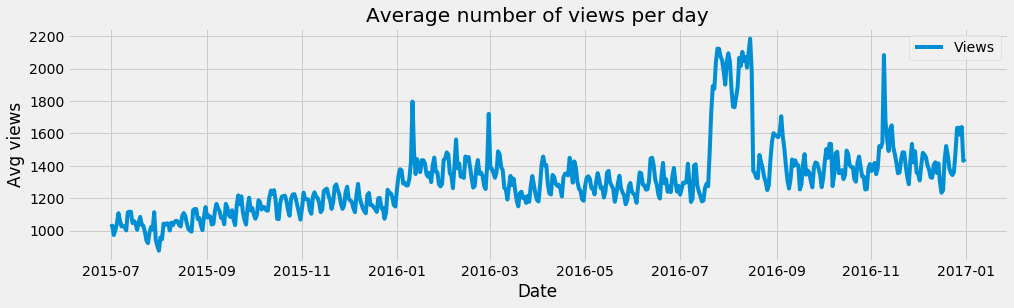

In [11]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

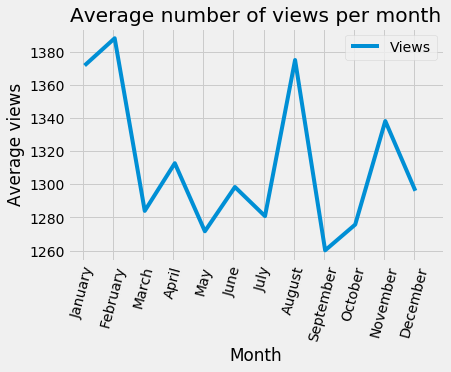

In [12]:
# Average number of views per month
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
ax.set_title('Average number of views per month')
plt.show()

In [16]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
temp1 = df_reshaped  
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


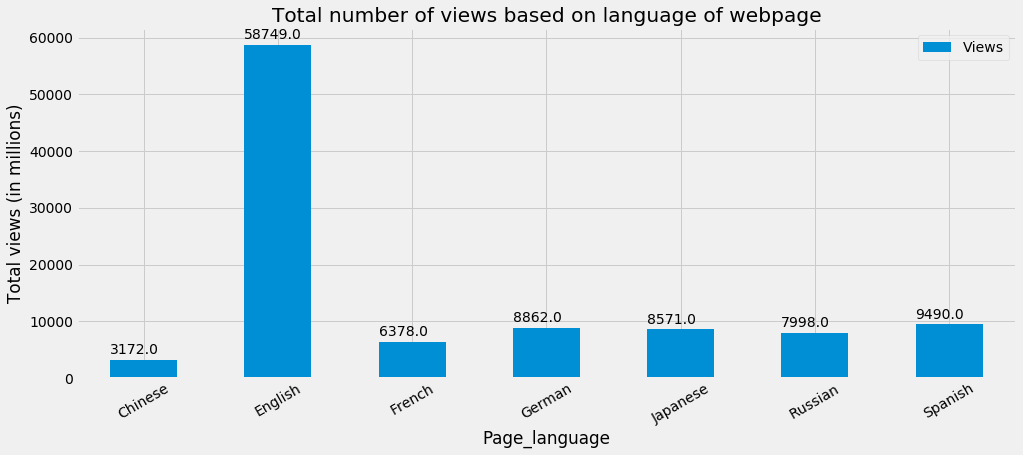

In [20]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [26]:
# Extracting day of week from date
days_df = df_reshaped.copy()
days_df = days_df[['Page','Views']]
days_df['Dayofweek'] = days_df.index.dayofweek

In [27]:
def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
days_df['Day'] = days_df.Dayofweek.apply(find_day)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


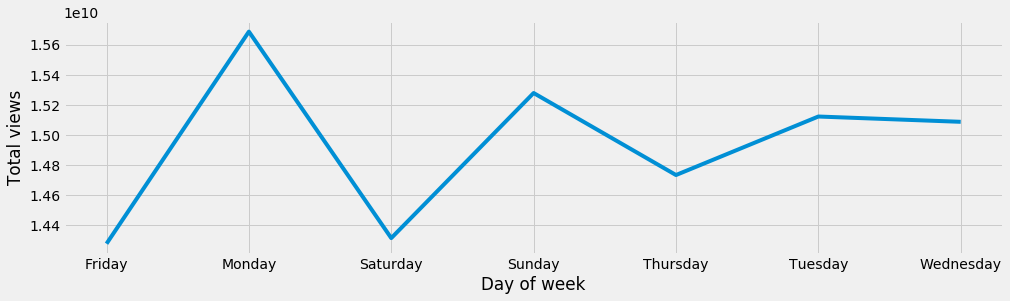

In [28]:
day = days_df.groupby('Day')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [32]:
# Top 5 pages with maximum number of views
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

In [34]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(top_pages_list)]

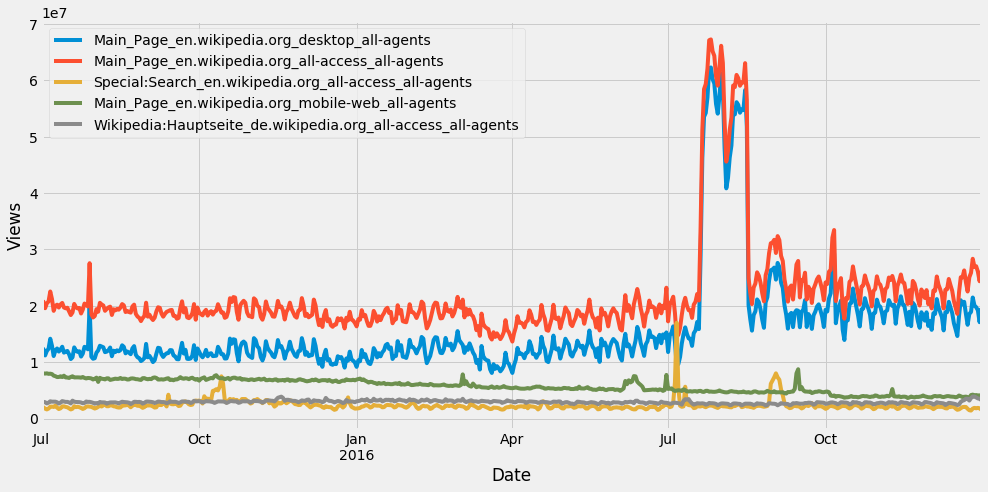

In [41]:
# Plot with top 5 pages which have maximum number of views
fig, ax = plt.subplots(figsize=(15,7))
for i in list(top5_pages_df.Page.unique())[:5]:
    top5_pages_df.loc[top5_pages_df.Page == i].plot(ax=ax)

ax.set_ylabel('Views')
ax.legend(list(top5_pages_df.Page.unique())[:5],loc='upper left')
plt.show()

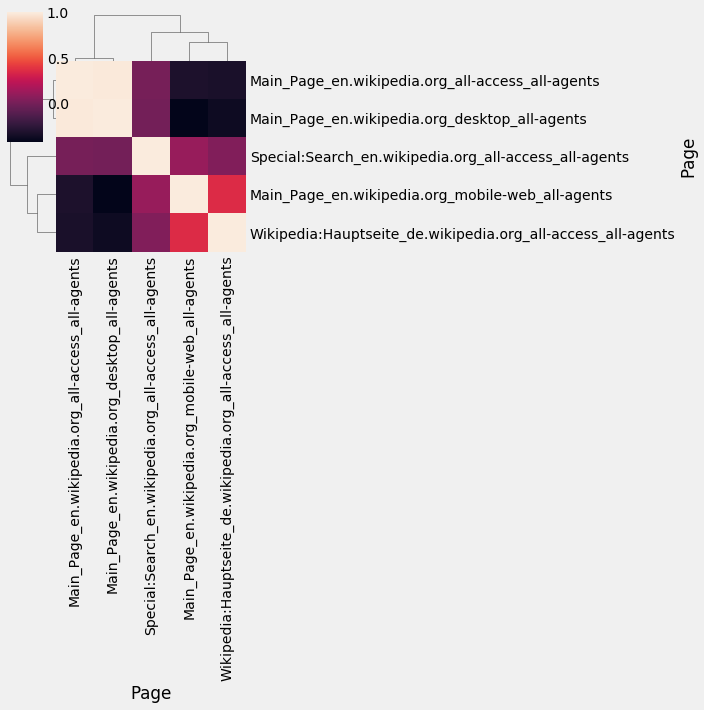

In [42]:
# Correlation between pages
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [45]:
# Time-series of page with maximum views
top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


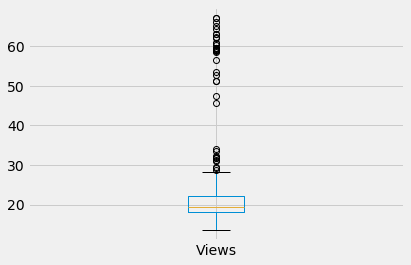

In [46]:
ax1 = top_page_df.boxplot()

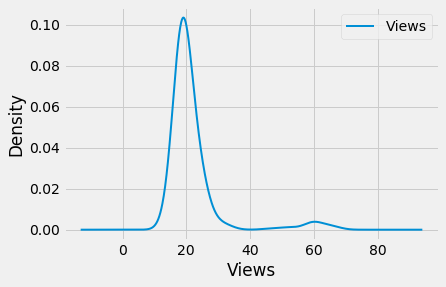

In [47]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

## Anomaly detection using Isolation Forest

In [48]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

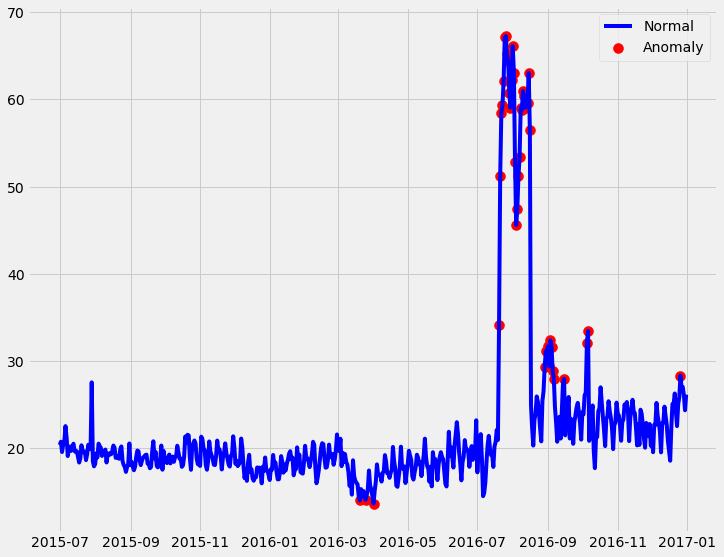

In [52]:
fig, ax = plt.subplots(figsize=(11,9))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Views'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Views'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

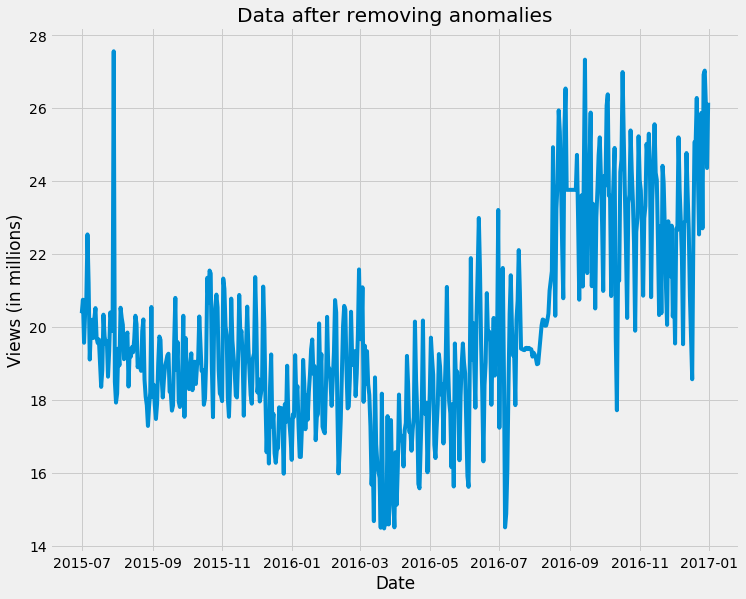

In [54]:
# Removing anomalies from the data
top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')

# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(11,9))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [55]:
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

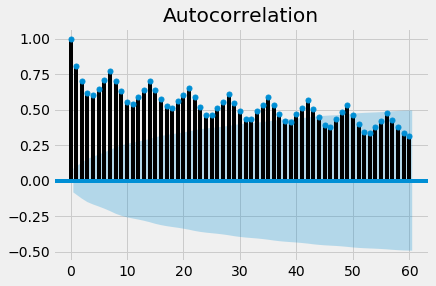

In [56]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

/Users/subikshaa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


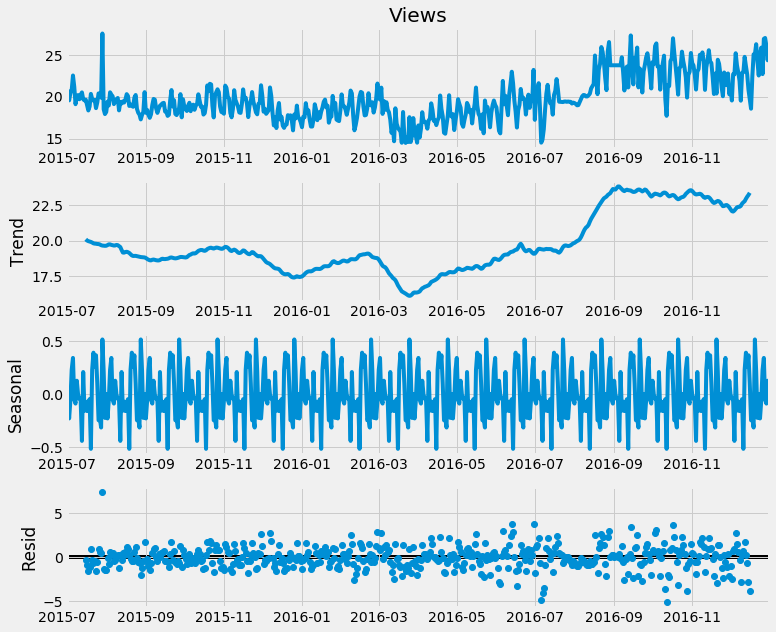

In [60]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views,freq = 30)
figure = ts_decomposition.plot()

### Augmented Dicky-Fuller test

In [61]:
test = adfuller(top_page_df['Views'])
print(test)

(-0.5312332176959887, 0.8857760944398629, 14, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1758.6451178785078)


 - First element is the test statistic. Test statistic shows how likely the data is stationary.
 - Second element indicates the p-value. Since the p-value is not < 0.05, we cannot reject null hypothesis. The null hypothesis is that data is not stationary. Therefore, data is not stationary.

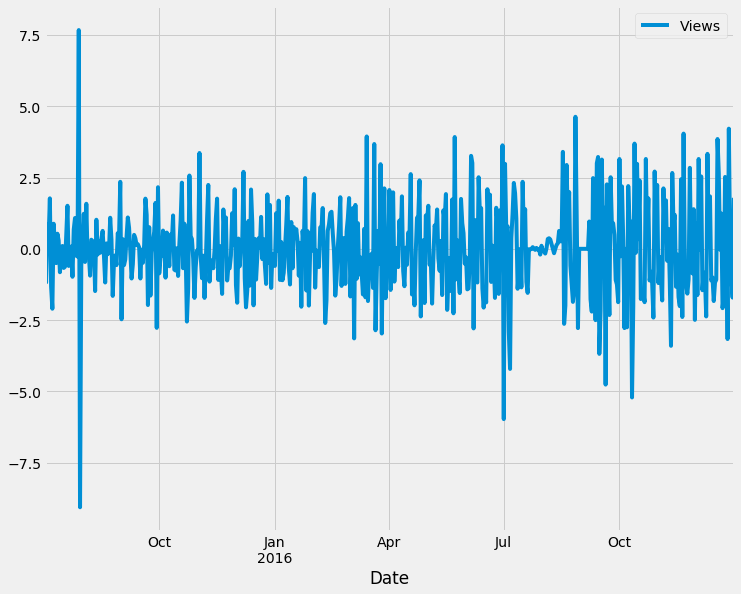

In [62]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [63]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-8.068820583383932, 1.5695934845304898e-12, 13, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1754.637299708165)


- We can see that the test statistic is more for stationary data. This means that the data is now more likely to be stationary.
- Since the p-value(second element) is less than 0.05, null hypothesis can be rejected. Therefore, data is stationary.

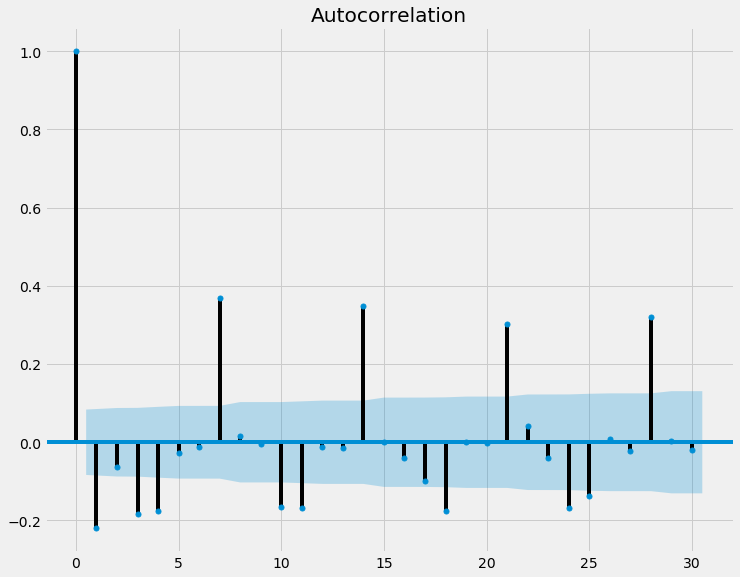

In [64]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

## Preparing the data for modeling

In [66]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

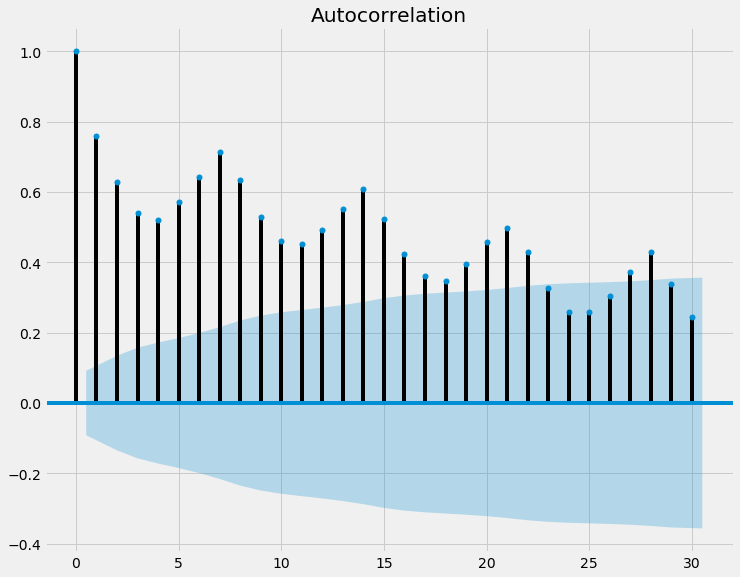

In [67]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

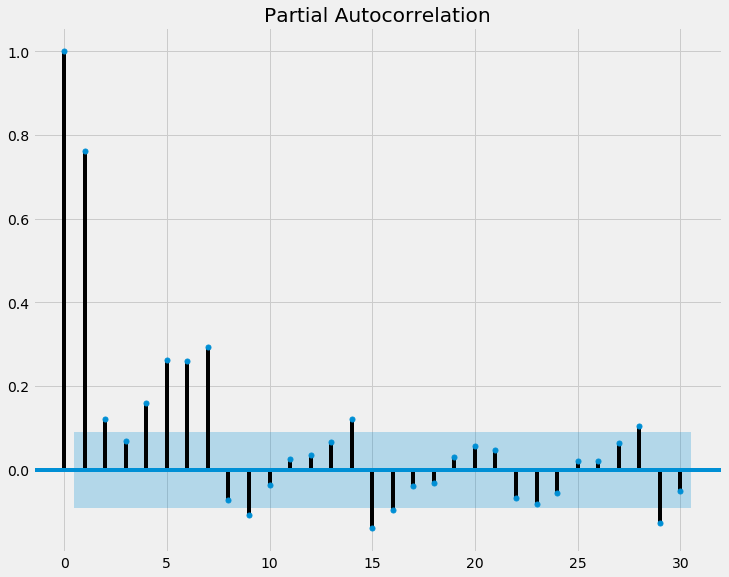

In [68]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## ARMA model

In [29]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
            print(p, q, result.aic, result.bic)
        except:
#             continue
            print(p,q,None,None)


ormation was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

0 5 2356.3840917470943 2381.1453068517794
I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

0 6 2260.305691647958 2289.1937759367574
1 0 1700.6232320927463 1708.8769704609747
I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information w

In [30]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values('aic')

In [31]:
aic_bic_df.head()

,p,q,aic,bic
25,3,4,1485.910470,1518.925424
32,4,4,1499.418541,1536.560363
42,6,2,1515.973807,1553.115629
44,6,4,1532.504718,1577.900279
41,6,1,1538.656720,1571.671674


### Prediction using ARMA 

In [32]:
model = SARIMAX(train,order=(3,0,4))
result = model.fit()

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [33]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

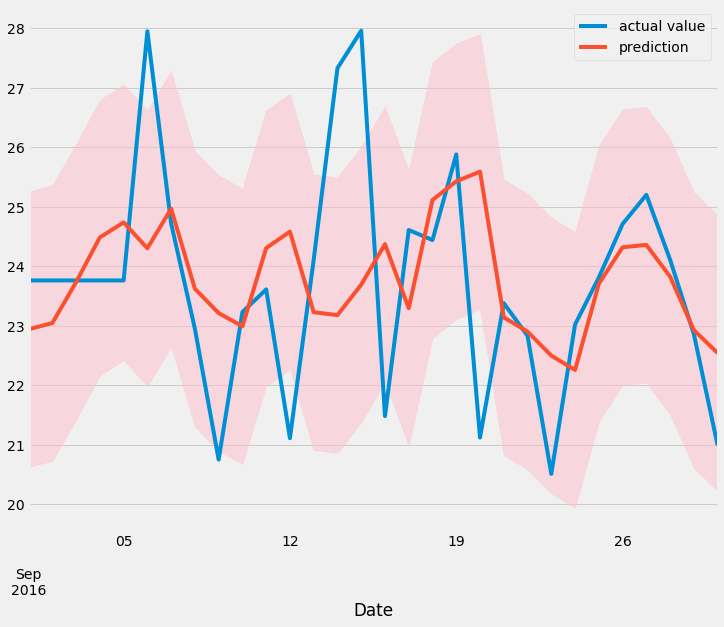

In [34]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

### Forecasting using ARMA model

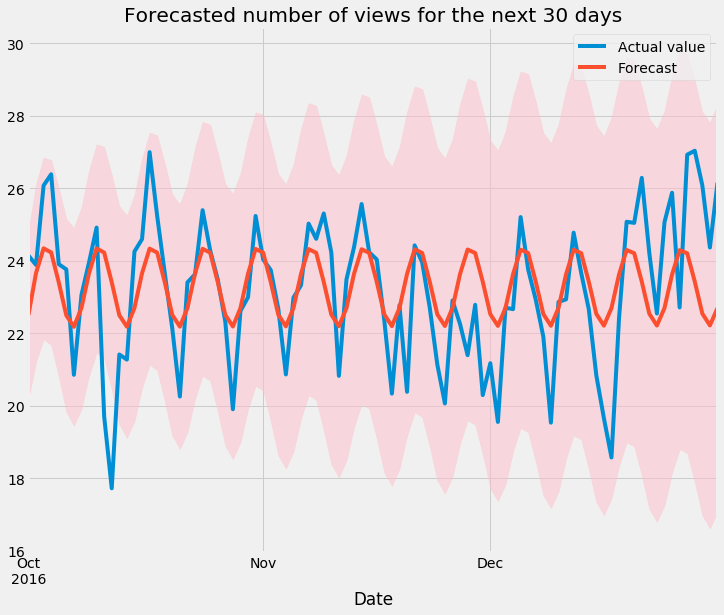

In [35]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [36]:
rmse_values = []
rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

## ARIMA model

In [37]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
print(arima_aic_bic_df.sort_values('aic'))

ite-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will 

### Prediction using ARIMA

In [38]:
arima_model = SARIMAX(train,order=(2,1,4))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

I:\Installed\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



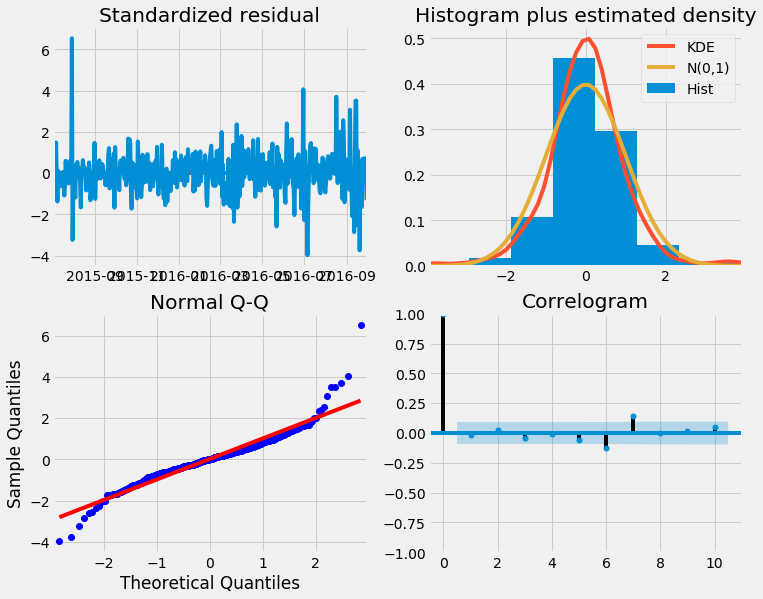

In [39]:
arima_result.plot_diagnostics()
plt.show()

In [40]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(2, 1, 4)   Log Likelihood                -728.616
Date:                Wed, 27 May 2020   AIC                           1471.232
Time:                        21:54:01   BIC                           1500.104
Sample:                    07-01-2015   HQIC                          1482.604
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2470      0.003    448.206      0.000       1.242       1.252
ar.L2         -0.9989      0.003   -396.293      0.000      -1.004      -0.994
ma.L1         -1.8732      0.033    -56.930      0.000      -1.938      -1.809
ma.L2          1.6359      0.064     25.375      0.000       1.510       1.762
ma.L3         -0.4464      0.065     -6.882      0.000      -0.573      -0.319
ma.L4         -0.1297      0.037     -3.487      0.000      -0.203      -0.057
sigma2         1.4248      0.060     23.667      0.000       1.307       1.543
===================================================================================
Ljung-Box (Q):                       51.70   Jarque-Bera (JB):               712.16
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

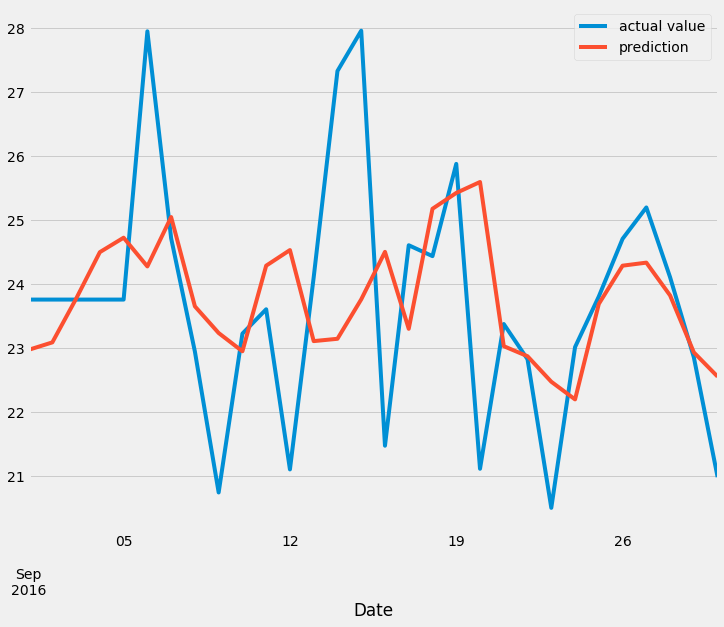

In [41]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

### Forecasting using ARIMA model

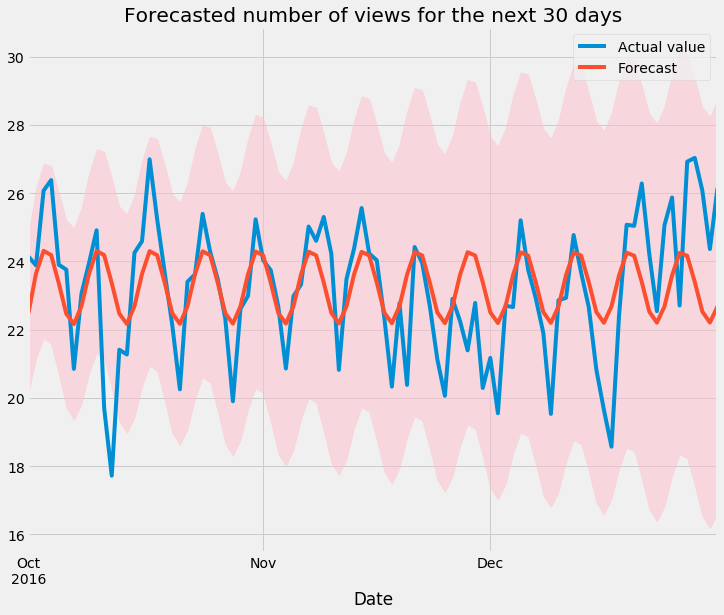

In [42]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [43]:
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))

## Exponential smoothing model

I:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



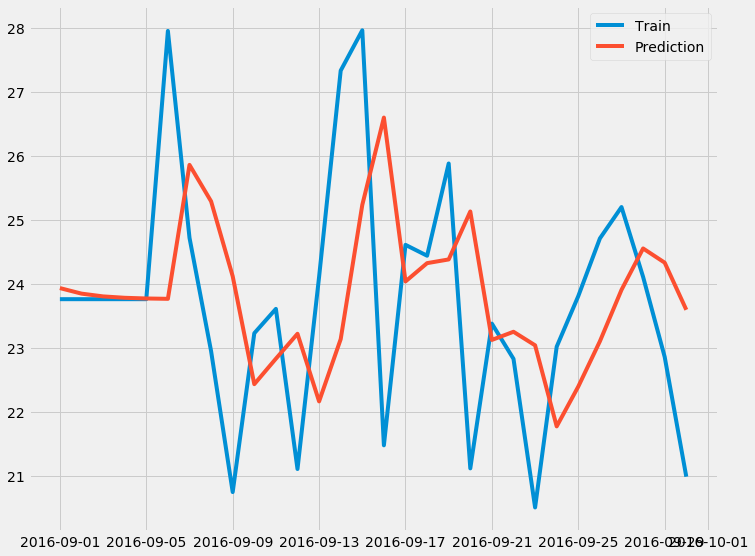

In [44]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)

# Prediction using Exponential Smoothing model
exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])

plt.plot(train[-30:], label='Train')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

### Forecasting using Exponential Smoothing model

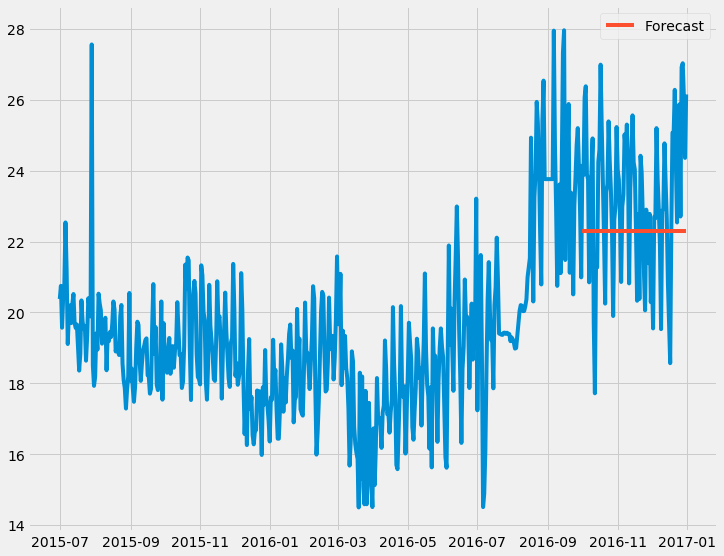

In [45]:
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])

plt.plot(top_page_df)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [46]:
rmse_values.append(('Exponential Smoothing',np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))

## Prophet

In [47]:
prophet_model = Prophet()
prophet_result = prophet_model.fit(train.reset_index().rename(columns={'Date':'ds','Views':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Prediction using Prophet

In [54]:
future = prophet_model.make_future_dataframe(periods=-30)
prophet_prediction = prophet_model.predict(future)

prediction = prophet_prediction[['ds','yhat_lower','yhat_upper','yhat']][-30:]
plt.plot(prediction['ds'],prediction['yhat'],label='Prediction')
plt.plot(train[-30:], label='Actual data')
# plt.fill_between(prophet_forecast['ds'],prophet_forecast['yhat_lower'],prophet_forecast['yhat_upper'])
plt.legend(loc='best')
plt.show()

OutOfBoundsDatetime: Cannot generate range with start=1475193600000000000 and periods=-29

### Forecasting using Prophet

In [ ]:
future = prophet_model.make_future_dataframe(periods=test.shape[0])
prophet_forecast = prophet_model.predict(future)

forecast = prophet_forecast[['ds','yhat_lower','yhat_upper','yhat']][-test.shape[0]:]
plt.plot(forecast['ds'],forecast['yhat'],label='forecast')
plt.plot(top_page_df, label='Actual data')
# # plt.fill_between(prophet_forecast['ds'],prophet_forecast['yhat_lower'],prophet_forecast['yhat_upper'])
plt.legend(loc='best')
plt.show()

In [ ]:
fig = prophet_model.plot_components(prophet_forecast)

In [ ]:
fig = prophet_model.plot(prophet_forecast)

In [55]:
rmse_values.append(('Prophet',np.sqrt(np.mean(np.square(forecast.yhat.values - test.Views.values)))))

In [62]:
auto_arima_model = auto_arima(train, trace=True, error_action='ignore',suppress_warnings=True)
auto_arima_model.fit(train)

# auto_arima_forecast = auto_arima_model.predict(n_periods=test.shape[0])
# auto_arima_forecast = pd.DataFrame(auto_arima_forecast,index = test.index,columns=['Prediction'])

# #plot the predictions for validation set
# plt.plot(train, label='Train')
# plt.plot(valid, label='Valid')
# plt.plot(auto_arima_forecast, label='Prediction')
# plt.show()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0

ValueError: Could not successfully fit ARIMA to input data. It is likely your data is non-stationary. Please induce stationarity or try a different range of model order params. If your data is seasonal, check the period (m) of the data.

### Root Mean Squared Error

In [56]:
rmse_df = pd.DataFrame(rmse_values,columns=['Model','RMSE_values']).sort_values('RMSE_values')
rmse_df

,Model,RMSE_values
1,ARIMA,1.724066
0,ARMA,1.724164
2,Exponential Smoothing,2.189830
3,Prophet,3.803075
4,Prophet,3.803075
